# Ensemble learning

## load data

In [145]:
import pandas as pd
import pickle
import os

In [146]:
df1 = pd.read_csv(
    os.path.join("result", "bert-base-cased_bs_8_epo7", "l2", "level2_softmax.csv")
)
df2 = pd.read_csv(
    os.path.join("result", "roberta-base_bs_8_epo10", "l2", "level2_softmax.csv")
)
df3 = pd.read_csv(
    os.path.join("result", "xlnet-base-cased_bs_8_epo10", "l2", "level2_softmax.csv")
)
df4 = pd.read_csv(
    os.path.join(
        "result",
        "google_electra-base-discriminator_bs_8_epo10",
        "l2",
        "level2_softmax.csv",
    )
)
df5 = pd.read_csv(
    os.path.join(
        "result", "microsoft_deberta-base_bs_4_epo9", "l2", "level2_softmax.csv"
    )
)

In [147]:
df1["sentiment"]

0       0.025889
1       0.002131
2       0.004950
3       0.055823
4       0.002406
          ...   
2343    0.992563
2344    0.002670
2345    0.985187
2346    0.003030
2347    0.069894
Name: sentiment, Length: 2348, dtype: float64

In [148]:
with open(os.path.join("data", "train_valid_split", "level_2", "y_l2.pkl"), "rb") as f:
    y = pickle.load(f)

In [149]:
X = pd.DataFrame(
    {
        "model_1": df1["sentiment"],
        "model_2": df2["sentiment"],
        "model_3": df3["sentiment"],
        "model_4": df4["sentiment"],
        "model_5": df5["sentiment"],
    }
)
X

,model_1,model_2,model_3,model_4,model_5
0,0.025889,0.003011,0.004297,0.009604,0.005394
1,0.002131,0.002943,0.000889,0.002825,0.000381
2,0.004950,0.002949,0.000739,0.004916,0.001335
3,0.055823,0.002976,0.009089,0.003739,0.001982
4,0.002406,0.002948,0.000767,0.002968,0.000456
...,...,...,...,...,...
2343,0.992563,0.996553,0.997342,0.988435,0.998907
2344,0.002670,0.002945,0.000779,0.002885,0.000744
2345,0.985187,0.996455,0.995898,0.985997,0.997631
2346,0.003030,0.002957,0.000789,0.002995,0.004879


In [150]:
y.values

array([0, 0, 0, ..., 1, 0, 0])

## 5-fold

In [151]:
from sklearn.model_selection import StratifiedKFold

In [152]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # init

In [153]:
tr_list_x = []
tr_list_y = []
va_list_x = []
va_list_y = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # train_index
    tr_list_x.append(X.iloc[train_index].values)
    tr_list_y.append(y.iloc[train_index].values)

    # test_index
    va_list_x.append(X.iloc[test_index].values)
    va_list_y.append(y.iloc[test_index].values)

    print(
        "Train Pos: {}, Neg: {}".format(
            sum(y.iloc[train_index] == 0), sum(y.iloc[train_index] == 1)
        )
    )

    print(
        "Valid Pos: {}, Neg: {}".format(
            sum(y.iloc[test_index] == 0), sum(y.iloc[test_index] == 1)
        )
    )

    print("=" * 40)

Train Pos: 890, Neg: 988
Valid Pos: 223, Neg: 247
Train Pos: 890, Neg: 988
Valid Pos: 223, Neg: 247
Train Pos: 890, Neg: 988
Valid Pos: 223, Neg: 247
Train Pos: 891, Neg: 988
Valid Pos: 222, Neg: 247
Train Pos: 891, Neg: 988
Valid Pos: 222, Neg: 247


In [50]:
tr_list_x[0]

array([[0.02588884, 0.00301065, 0.00429728, 0.00960365, 0.00539435],
       [0.00213117, 0.0029434 , 0.00088919, 0.00282461, 0.00038069],
       [0.05582312, 0.00297602, 0.00908886, 0.00373885, 0.00198184],
       ...,
       [0.00266983, 0.00294544, 0.0007793 , 0.0028846 , 0.00074437],
       [0.00302999, 0.00295661, 0.00078902, 0.00299497, 0.00487888],
       [0.06989356, 0.0030087 , 0.00202729, 0.16549522, 0.00962536]])

## pytorch

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [142]:
plt.rcParams["figure.figsize"] = (12, 8)

In [65]:
def check_gpu():
    """
    Check if GPU avaliable.
    """
    print()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    print()

    return device


device = check_gpu()


There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti



In [51]:
class Data(Dataset):
    # Constructor
    def __init__(self, X, y):
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.len = self.y.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

In [53]:
# create dataset
tr_set = []
va_set = []

for idx in range(len(tr_list_x)):
    tr_set.append(Data(tr_list_x[idx], tr_list_y[idx]))

for idx in range(len(va_list_x)):
    va_set.append(Data(va_list_x[idx], va_list_y[idx]))

In [165]:
class NN(nn.Module):
    # Constructor
    def __init__(self, input_dim, neuron=8, p=0):
        super().__init__()

        self.input_dim = input_dim

        self.neuron = neuron

        self.layer = torch.nn.Sequential(
            # 1
            nn.Linear(self.input_dim, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(p=p),
            # 2
            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(p=p),
            # 3
            nn.Linear(self.neuron, 2),
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [166]:
def batch_iter(
    model, dataloader, optimizer, scheduler, device, criterion, training=True
):

    correct = 0
    training_loss = 0
    TP = FP = TN = FN = 0
    y_list = []
    yhat_list = []

    if training:
        model.train()
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            yhat_prob = F.softmax(z, dim=1)[:, 1]

            # calc metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()

            # calc auc
            y_list.extend(y.cpu().detach().numpy())
            yhat_list.extend(yhat_prob.cpu().detach().numpy())

    else:
        model.eval()
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                z = model(x)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y).sum().item()
                loss = criterion(z, y)
                training_loss += loss.item()
                yhat_prob = F.softmax(z, dim=1)[:, 1]

                # calc metric
                TP += ((yhat == 1) & (y == 1)).sum().item()
                FP += ((yhat == 1) & (y == 0)).sum().item()
                TN += ((yhat == 0) & (y == 0)).sum().item()
                FN += ((yhat == 0) & (y == 1)).sum().item()

                # calc auc
                y_list.extend(y.cpu().detach().numpy())
                yhat_list.extend(yhat_prob.cpu().detach().numpy())

    return model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list

In [167]:
def calc_metrics(
    N_data,
    dataloader,
    correct,
    training_loss,
    confusion_matrix,
    y_list,
    yhat_list,
    useful_stuff,
    mtype,
):
    (TP, FP, TN, FN) = confusion_matrix
    fpr, tpr, _ = metrics.roc_curve(y_list, yhat_list)
    auc = metrics.auc(fpr, tpr)
    acc = correct / N_data
    loss = training_loss / len(dataloader)
    useful_stuff = save_result(
        useful_stuff, acc, loss, (TP, FP, TN, FN), auc, fpr, tpr, mtype
    )

    return useful_stuff

In [168]:
def save_result(useful_stuff, acc, loss, confusion_matrix, auc, fpr, tpr, type):
    (TP, FP, TN, FN) = confusion_matrix
    useful_stuff[type + "_loss"].append(loss)
    useful_stuff[type + "_acc"].append(acc)
    useful_stuff[type + "_metric"].append((TP, FP, TN, FN))
    useful_stuff[type + "_auc"].append(auc)
    useful_stuff[type + "_fpr"].append(fpr)
    useful_stuff[type + "_tpr"].append(tpr)
    return useful_stuff

In [169]:
def train_ensemble(
    model,
    train_loader,
    valid_loader,
    optimizer,
    N_train,
    N_test,
    device,
    criterion,
    scheduler,
    epochs=20,
):

    useful_stuff = {
        "training_loss": [],
        "training_acc": [],
        "training_auc": [],
        "training_metric": [],
        "training_fpr": [],
        "training_tpr": [],
        "train_loss": [],
        "train_acc": [],
        "train_auc": [],
        "train_metric": [],
        "train_fpr": [],
        "train_tpr": [],
        "valid_loss": [],
        "valid_acc": [],
        "valid_auc": [],
        "valid_metric": [],
        "valid_fpr": [],
        "valid_tpr": [],
    }

    for epoch in range(epochs):

        # training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=True
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="training",
        )

        # evaluate training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="train",
        )

        # Validation
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, valid_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_test,
            valid_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="valid",
        )

        scheduler.step(training_loss)
        print(
            "[Epo {:2}] tr_acc: {:.2f} tr_oss: {:.2f} va_acc: {:.2f} va_loss: {:.2f}".format(
                epoch,
                useful_stuff["train_acc"][-1],
                useful_stuff["train_loss"][-1],
                useful_stuff["valid_acc"][-1],
                useful_stuff["valid_loss"][-1],
            )
        )

    return useful_stuff

In [120]:
# hypterparameter
epochs = 60
batch_size = 32
lr = 2e-4
dropout_rate = 0.1
neuron = 10
print("epochs:", epochs)
print("batch_size:", batch_size)
print("learning rate:", lr)
print("dropout_rate:", dropout_rate)
print("neurons per layer:", neuron)

epochs: 60
batch_size: 32
learning rate: 0.0002
dropout_rate: 0.1
neurons per layer: 10


In [121]:
# training
training_hist = []
for fold in range(5):

    model = NN(input_dim=5, neuron=neuron, p=dropout_rate)
    model.to(device)

    N_train = len(tr_set[fold])
    N_test = len(va_set[fold])
    print("[Fold]:", fold)
    print("Num of train samples:", N_train)
    print("Num of valid samples:", N_test)
    print()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
    )

    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=10, factor=0.5, verbose=True
    )

    tr_loader = DataLoader(tr_set[fold], shuffle=True, batch_size=batch_size)

    va_loader = DataLoader(va_set[fold], shuffle=False, batch_size=batch_size * 8)

    useful_stuff = train_ensemble(
        model=model,
        train_loader=tr_loader,
        valid_loader=va_loader,
        optimizer=optimizer,
        N_train=N_train,
        N_test=N_test,
        device=device,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs,
    )

    training_hist.append(useful_stuff)
    print("*" * 50)
    print("*" * 50)
    print("*" * 50)

[Fold]: 0
Num of train samples: 1878
Num of valid samples: 470

[Epo  0] tr_acc: 0.52 tr_oss: 0.64 va_acc: 0.53 va_loss: 0.63
[Epo  1] tr_acc: 0.52 tr_oss: 0.57 va_acc: 0.53 va_loss: 0.56
[Epo  2] tr_acc: 0.90 tr_oss: 0.49 va_acc: 0.91 va_loss: 0.48
[Epo  3] tr_acc: 0.90 tr_oss: 0.45 va_acc: 0.91 va_loss: 0.44
[Epo  4] tr_acc: 0.91 tr_oss: 0.43 va_acc: 0.91 va_loss: 0.41
[Epo  5] tr_acc: 0.92 tr_oss: 0.39 va_acc: 0.92 va_loss: 0.38
[Epo  6] tr_acc: 0.92 tr_oss: 0.36 va_acc: 0.93 va_loss: 0.36
[Epo  7] tr_acc: 0.92 tr_oss: 0.34 va_acc: 0.93 va_loss: 0.34
[Epo  8] tr_acc: 0.92 tr_oss: 0.32 va_acc: 0.93 va_loss: 0.31
[Epo  9] tr_acc: 0.93 tr_oss: 0.30 va_acc: 0.94 va_loss: 0.30
[Epo 10] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.94 va_loss: 0.28
[Epo 11] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.94 va_loss: 0.27
[Epo 12] tr_acc: 0.94 tr_oss: 0.26 va_acc: 0.94 va_loss: 0.26
[Epo 13] tr_acc: 0.94 tr_oss: 0.25 va_acc: 0.94 va_loss: 0.25
[Epo 14] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.94 va_loss: 0.24
[Epo 1

[Epo  4] tr_acc: 0.92 tr_oss: 0.43 va_acc: 0.90 va_loss: 0.44
[Epo  5] tr_acc: 0.92 tr_oss: 0.40 va_acc: 0.90 va_loss: 0.42
[Epo  6] tr_acc: 0.92 tr_oss: 0.37 va_acc: 0.91 va_loss: 0.39
[Epo  7] tr_acc: 0.93 tr_oss: 0.35 va_acc: 0.91 va_loss: 0.36
[Epo  8] tr_acc: 0.93 tr_oss: 0.33 va_acc: 0.91 va_loss: 0.35
[Epo  9] tr_acc: 0.93 tr_oss: 0.30 va_acc: 0.91 va_loss: 0.33
[Epo 10] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.92 va_loss: 0.32
[Epo 11] tr_acc: 0.93 tr_oss: 0.28 va_acc: 0.92 va_loss: 0.30
[Epo 12] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.91 va_loss: 0.29
[Epo 13] tr_acc: 0.93 tr_oss: 0.26 va_acc: 0.92 va_loss: 0.28
[Epo 14] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.91 va_loss: 0.27
[Epo 15] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.91 va_loss: 0.27
[Epo 16] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.91 va_loss: 0.26
[Epo 17] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.91 va_loss: 0.25
[Epo 18] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.25
[Epo 19] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.25
[Epo 20]

[Epo  7] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.92 va_loss: 0.30
[Epo  8] tr_acc: 0.93 tr_oss: 0.28 va_acc: 0.92 va_loss: 0.29
[Epo  9] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.92 va_loss: 0.27
[Epo 10] tr_acc: 0.93 tr_oss: 0.26 va_acc: 0.92 va_loss: 0.26
[Epo 11] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.92 va_loss: 0.25
[Epo 12] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.92 va_loss: 0.24
[Epo 13] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.92 va_loss: 0.23
[Epo 14] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.93 va_loss: 0.22
[Epo 15] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.93 va_loss: 0.22
[Epo 16] tr_acc: 0.94 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.22
[Epo 17] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 18] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 19] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 20] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.20
[Epo 21] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 22] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 23]

## Metrics

In [128]:
def calc_metric_ensemble(history, train_metric=True, detail=False):
    """
    Calculate metric.
    """
    # init
    ACC = []
    LOSS = []
    RECALL = []
    SPECIFICITY = []
    PRECISION = []
    NPV = []
    F1 = []
    MCC = []
    AUC = []
    FPR = []
    TPR = []

    for i in range(len(history)):

        if train_metric:
            (TP, FP, TN, FN) = history[i]["train_metric"][-1]
            auc = history[i]["train_auc"][-1]
            fpr = history[i]["train_fpr"][-1]
            tpr = history[i]["train_tpr"][-1]
            loss = history[i]["train_loss"][-1]
        else:
            (TP, FP, TN, FN) = history[i]["valid_metric"][-1]
            auc = history[i]["valid_auc"][-1]
            fpr = history[i]["valid_fpr"][-1]
            tpr = history[i]["valid_tpr"][-1]
            loss = history[i]["valid_loss"][-1]

        acc = (TP + TN) / (TP + FP + TN + FN)

        try:
            recall = TP / (TP + FN)  # 召回率是在所有正樣本當中，能夠預測多少正樣本的比例
        except:
            recall = 0

        try:
            specificity = TN / (TN + FP)  # 特異度是在所有負樣本當中，能夠預測多少負樣本的比例
        except:
            specificity = 0

        try:
            precision = TP / (TP + FP)  # 準確率為在所有預測為正樣本中，有多少為正樣本
        except:
            precision = 0

        try:
            npv = TN / (TN + FN)  # npv為在所有預測為正樣本中，有多少為正樣本
        except:
            npv = 0

        try:
            f1 = (2 * recall * precision) / (recall + precision)  # F1-score則是兩者的調和平均數
        except:
            f1 = 0

        try:
            mcc = (TP * TN - FP * FN) / np.sqrt(
                ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
            )
        except:
            mcc = 0

        if detail:
            print("[ fold", i, "]", "(Total sample: {})".format(TP + FP + TN + FN))
            print("TP:", TP)
            print("FP:", FP)
            print("TN:", TN)
            print("FN:", FN)
            print()
            print("acc:", acc)
            print("loss:", loss)
            print("recall:", recall)
            print("specificity:", specificity)
            print("precision:", precision)
            print("npv:", npv)
            print("f1:", f1)
            print("mcc:", mcc)
            print("auc:", auc)
            print("fpr:", fpr)
            print("tpr:", tpr)
            print("=" * 40)

        ACC.append(acc)
        LOSS.append(loss)
        RECALL.append(recall)
        SPECIFICITY.append(specificity)
        PRECISION.append(precision)
        NPV.append(npv)
        F1.append(f1)
        MCC.append(mcc)
        AUC.append(auc)
        FPR.append(fpr)
        TPR.append(tpr)

    if train_metric:
        print("\n[Training average]\n")
    else:
        print("\n[valid average]\n")
    print("ACC: {:.2}".format((np.mean(ACC))))
    print("LOSS: {:.2}".format(np.mean(LOSS)))
    print()
    print("Recall: {:.2}".format(np.mean(RECALL)))
    print("Specificity: {:.2}".format(np.mean(SPECIFICITY)))
    print("Precision: {:.2}".format(np.mean(PRECISION)))
    print("NPV: {:.2}".format(np.mean(NPV)))
    print()
    print("F1: {:.2}".format(np.mean(F1)))
    print("MCC: {:.2}".format(np.mean(MCC)))
    print("AUC: {:.2}".format(np.mean(AUC)))
    print()

In [ ]:
calc_metric_ensemble(training_hist, train_metric=True, detail=False)
calc_metric_ensemble(training_hist, train_metric=False, detail=False)

## Learning curve

In [132]:
def plot_roc(history, mtype="train"):
    """
    plot roc curve and save as png
    """
    for i in range(len(history)):
        auc = history[i][mtype + "_auc"][-1]
        fpr = history[i][mtype + "_fpr"][-1]
        tpr = history[i][mtype + "_tpr"][-1]

        plt.plot(fpr, tpr, label="Fold-" + str(i) + " AUC = %0.2f" % auc)

    plt.title(mtype + " roc curve")
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    #     plt.savefig(fig_path + mtype + "-roc" + ".png", bbox_inches="tight")
    #     plt.close()
    plt.show()

In [135]:
def calc_avg(history):
    """
    Plot learning curve
    """

    a1 = a2 = a3 = a4 = []  # init

    for i in range(len(history)):
        if i == 0:
            a1 = np.array(history[0]["train_loss"].copy())
            a2 = np.array(history[0]["valid_loss"].copy())
            a3 = np.array(history[0]["train_acc"].copy())
            a4 = np.array(history[0]["valid_acc"].copy())
            continue
        a1 = a1 + np.array(history[i]["train_loss"])
        a2 = a2 + np.array(history[i]["valid_loss"])
        a3 = a3 + np.array(history[i]["train_acc"])
        a4 = a4 + np.array(history[i]["valid_acc"])

    a1 /= len(history)
    a2 /= len(history)
    a3 /= len(history)
    a4 /= len(history)

    a1 = a1.tolist()
    a2 = a2.tolist()
    a3 = a3.tolist()
    a4 = a4.tolist()

    return a1, a2, a3, a4

In [136]:
def plot_lc_ensemble(history):

    a1, a2, a3, a4 = calc_avg(history)

    # color
    tr_color = ["#2ff5f2", "#2ff5e8", "#2ff5c0", "#2fbdf5", "#2f99f5"]
    val_color = ["#f5952f", "#f5ac2f", "#f5c02f", "#f5d72f", "#f5ee2f"]

    # train loss
    for idx, color in enumerate(tr_color):
        plt.plot(
            history[idx]["train_loss"],
            "--",
            alpha=0.4,
            label="train" + str(idx),
            color=color,
        )
    plt.plot(a1, label="average training")

    # valid loss
    for idx, color in enumerate(val_color):
        plt.plot(
            history[idx]["valid_loss"],
            "--",
            alpha=0.4,
            label="valid" + str(idx),
            color=color,
        )

    plt.plot(a2, label="average valid")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.legend()
    plt.title("training / valid loss vs iterations")
    plt.grid()
    #     plt.savefig(fig_path + "loss" + ".png", bbox_inches="tight")
    #     plt.close()
    plt.show()

    # train acc
    for idx, color in enumerate(tr_color):
        plt.plot(
            history[idx]["train_acc"],
            "--",
            alpha=0.4,
            label="train" + str(idx),
            color=color,
        )
    plt.plot(a3, label="average training")

    # valid acc
    for idx, color in enumerate(val_color):
        plt.plot(
            history[idx]["valid_acc"],
            "--",
            alpha=0.4,
            label="valid" + str(idx),
            color=color,
        )
    plt.plot(a4, label="average valid")
    plt.ylabel("acc")
    plt.xlabel("epochs")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.legend()
    plt.title("training / valid acc vs iterations")
    plt.grid()
    plt.show()
    # plt.savefig(fig_path + "acc" + ".png", bbox_inches="tight")
    # plt.close()

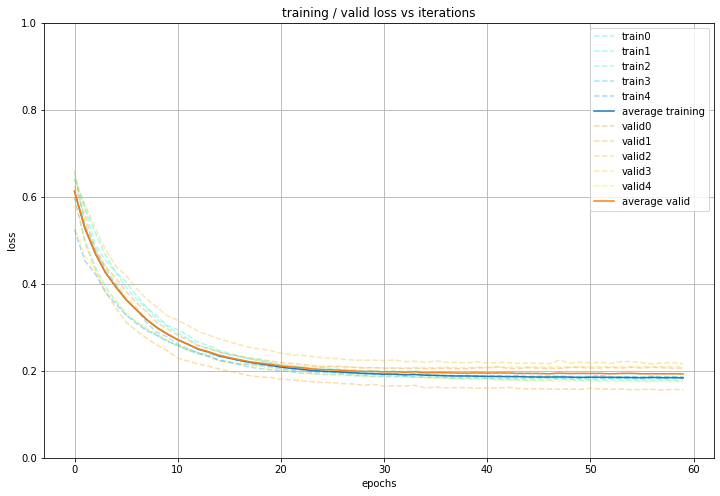

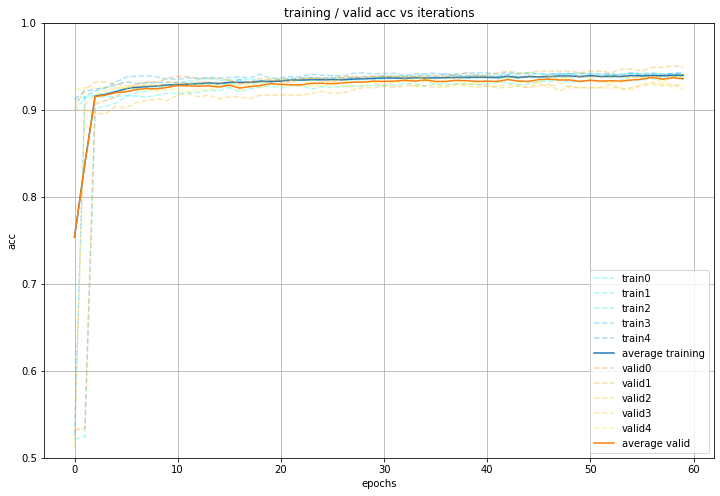

In [143]:
plot_lc_ensemble(training_hist)

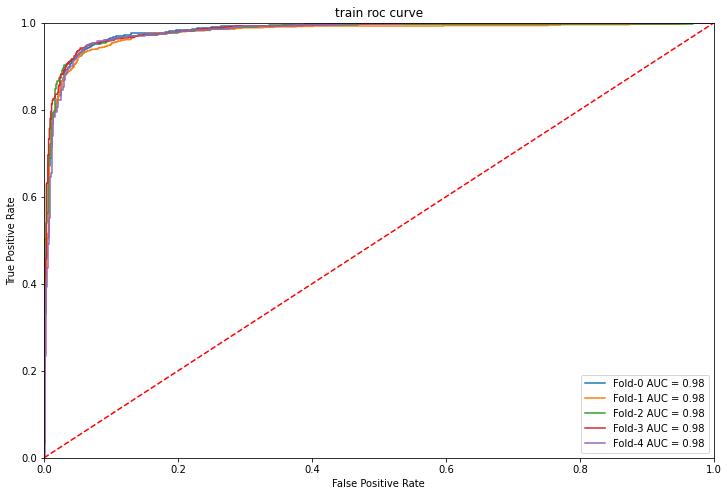

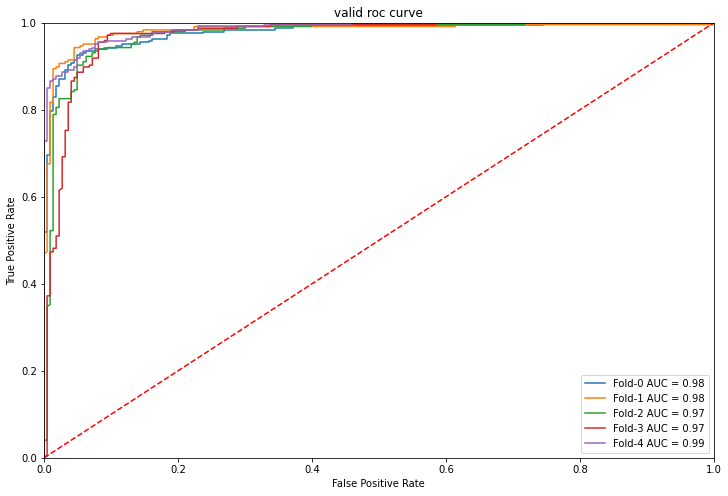

In [144]:
# roc
plot_roc(training_hist, mtype="train")
plot_roc(training_hist, mtype="valid")

## Final model

In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [155]:
def check_gpu():
    """
    Check if GPU avaliable.
    """
    print()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    print()

    return device


device = check_gpu()


There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti



In [171]:
class Data(Dataset):
    # Constructor
    def __init__(self, X, y):
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.len = self.y.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

In [172]:
dataset = Data(X.values, y.values)

In [173]:
len(dataset)

2348

In [179]:
def train_model_final(
    model, train_loader, optimizer, N_train, device, criterion, scheduler, epochs=10
):
    """
    Training the final model.
    """

    useful_stuff = {
        "training_loss": [],
        "training_acc": [],
        "training_auc": [],
        "training_metric": [],
        "training_fpr": [],
        "training_tpr": [],
        "train_loss": [],
        "train_acc": [],
        "train_auc": [],
        "train_metric": [],
        "train_fpr": [],
        "train_tpr": [],
    }

    for epoch in range(epochs):

        # training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=True
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="training",
        )

        # evaluate training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="train",
        )

    return useful_stuff

In [174]:
# hypterparameter
epochs = 60
batch_size = 32
lr = 2e-4
dropout_rate = 0.1
neuron = 10
print("epochs:", epochs)
print("batch_size:", batch_size)
print("learning rate:", lr)
print("dropout_rate:", dropout_rate)
print("neurons per layer:", neuron)

epochs: 60
batch_size: 32
learning rate: 0.0002
dropout_rate: 0.1
neurons per layer: 10


In [181]:
model = NN(input_dim=5, neuron=neuron, p=dropout_rate)
model.to(device)

N_train = len(dataset)
print("[Fold]:", fold)
print("Num of train samples:", N_train)
print("Num of valid samples:", N_test)
print()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=10, factor=0.5, verbose=True
)

tr_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

useful_stuff = train_model_final(
    model=model,
    train_loader=tr_loader,
    optimizer=optimizer,
    N_train=N_train,
    device=device,
    criterion=criterion,
    scheduler=scheduler,
    epochs=epochs,
)

[Fold]: 4
Num of train samples: 2348
Num of valid samples: 469



In [183]:
def calc_metric_final(useful_stuff):
    """
    calculate metrics.
    args:
        useful_stuff(dict): infomation dict, obtaining acc, loss, auc, ...
        fig_path(str): path to store figures
        data_index(int): what dataset is
    """
    (TP, FP, TN, FN) = useful_stuff["train_metric"][-1]

    acc = (TP + TN) / (TP + FP + TN + FN)
    loss = useful_stuff["train_loss"][-1]

    recall = TP / (TP + FN)  # 召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP)  # 特異度是在所有負樣本當中，能夠預測多少負樣本的比例
    precision = TP / (TP + FP)  # 準確率為在所有預測為正樣本中，有多少為正樣本
    npv = TN / (TN + FN)  # npv為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision) / (recall + precision)  # F1-score則是兩者的調和平均數
    mcc = (TP * TN - FP * FN) / np.sqrt(((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
    auc = useful_stuff["train_auc"][-1]

    print("\n[Training]\n")
    print("total sample:", (TP + FP + TN + FN))
    print("TP: {:.2f}".format(TP))
    print("FP: {:.2f}".format(FP))
    print("TN: {:.2f}".format(TN))
    print("FN: {:.2f}".format(FN))
    print("acc: {:.2f}".format(acc))
    print("loss: {:.2f}".format(loss))
    print("recall: {:.2f}".format(recall))
    print("specificity: {:.2f}".format(specificity))
    print("precision: {:.2f}".format(precision))
    print("npv: {:.2f}".format(npv))
    print("f1: {:.2f}".format(f1))
    print("mcc: {:.2f}".format(mcc))
    print("auc: {:.2f}".format(auc))

In [184]:
calc_metric_final(useful_stuff)


[Training]

total sample: 2348
TP: 1158.00
FP: 70.00
TN: 1043.00
FN: 77.00
acc: 0.94
loss: 0.18
recall: 0.94
specificity: 0.94
precision: 0.94
npv: 0.93
f1: 0.94
mcc: 0.87
auc: 0.98


In [193]:
# save model
torch.save(model.state_dict(), "./result/nn_ensemble.pkl")

### learning curve

In [186]:
def plot_lc_final(useful_stuff):
    """
    plot learning curve.
    """
    # acc
    plt.plot(useful_stuff["train_acc"], label="train")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.title("train acc vs epochs")
    plt.grid()
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.show()

    # loss
    plt.plot(useful_stuff["train_loss"], label="train")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("train loss vs epochs")
    plt.grid()
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.show()

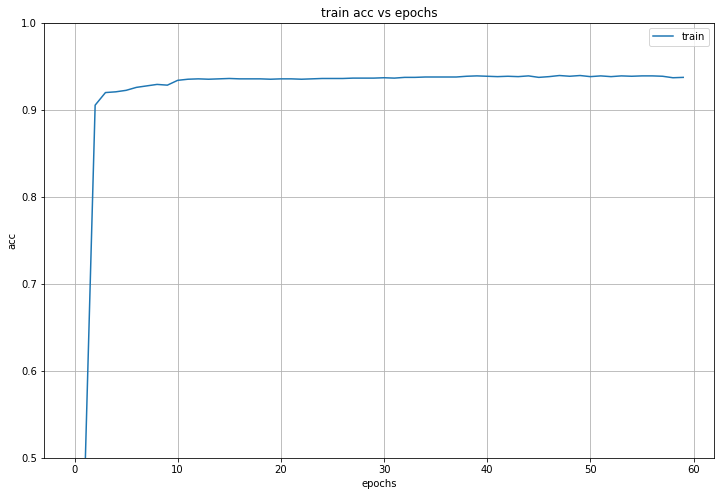

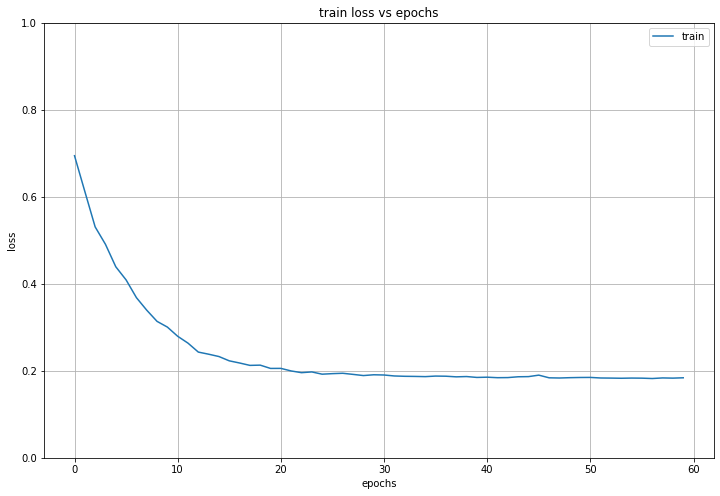

In [187]:
plot_lc_final(useful_stuff)

## Prediction

In [188]:
import pandas as pd
import pickle

In [194]:
df1 = pd.read_csv(
    os.path.join(
        "result", "bert-base-cased_bs_8_epo7", "predict", "submission_softmax.csv"
    )
)
df2 = pd.read_csv(
    os.path.join(
        "result", "roberta-base_bs_8_epo10", "predict", "submission_softmax.csv"
    )
)
df3 = pd.read_csv(
    os.path.join(
        "result", "xlnet-base-cased_bs_8_epo10", "predict", "submission_softmax.csv"
    )
)
df4 = pd.read_csv(
    os.path.join(
        "result",
        "google_electra-base-discriminator_bs_8_epo10",
        "predict",
        "submission_softmax.csv",
    )
)
df5 = pd.read_csv(
    os.path.join(
        "result",
        "microsoft_deberta-base_bs_4_epo9",
        "predict",
        "submission_softmax.csv",
    )
)

In [195]:
test = pd.DataFrame(
    {
        "model_1": df1["sentiment"],
        "model_2": df2["sentiment"],
        "model_3": df3["sentiment"],
        "model_4": df4["sentiment"],
        "model_5": df5["sentiment"],
    }
)
test

,model_1,model_2,model_3,model_4,model_5
0,0.870198,0.003108,0.005370,0.915819,0.000896
1,0.996770,0.996557,0.998085,0.986279,0.999026
2,0.010841,0.002949,0.000748,0.002883,0.002021
3,0.001926,0.002945,0.000840,0.003006,0.000451
4,0.552396,0.003029,0.993707,0.983890,0.996994
...,...,...,...,...,...
29336,0.018053,0.002986,0.004687,0.005666,0.001542
29337,0.997157,0.996579,0.998256,0.991592,0.999037
29338,0.004514,0.002961,0.009045,0.003469,0.001509
29339,0.006023,0.002964,0.000840,0.003573,0.001907


In [216]:
class Data(Dataset):
    # Constructor
    def __init__(self, X):
        self.x = torch.from_numpy(X).float()
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index]

    # Get Length
    def __len__(self):
        return self.len

In [217]:
dataset = Data(test.values)

In [218]:
len(dataset)

29341

In [219]:
test_loader = DataLoader(dataset, shuffle=False, batch_size=64)

In [221]:
model.eval()
prediction = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        z = model(x)
        _, yhat = torch.max(z.data, 1)
        prediction.extend(yhat.cpu().tolist())

In [222]:
len(prediction)

29341

### submission

In [226]:
with open("./data/test_rm_br.pkl", "rb") as f:
    test = pickle.load(f)

In [227]:
test

,ID,review
0,22622,Robert Lansing plays a scientist experimenting...
1,10162,"Well I've enjoy this movie, even though someti..."
2,17468,First things first - though I believe Joel Sch...
3,42579,I watched this movie on the grounds that Amber...
4,701,A certain sexiness underlines even the dullest...
...,...,...
29336,30370,It is difficult to rate a writer/director's fi...
29337,18654,"After watching this movie once, it quickly bec..."
29338,47985,"Even though i sat and watched the whole thing,..."
29339,9866,Warning Spoilers following. Superb recreation ...


In [229]:
df = pd.DataFrame({"ID":test.ID, "sentiment":prediction})
df

,ID,sentiment
0,22622,0
1,10162,1
2,17468,0
3,42579,0
4,701,1
...,...,...
29336,30370,0
29337,18654,1
29338,47985,0
29339,9866,0


In [230]:
df.to_csv('./result/nn_ensemble.csv', index=False, encoding='utf-8')